In [ ]:
!pip install -q nltk
!pip install -q rouge-score

In [ ]:
no_of_epochs = 1
size_batch = 64
example_sent = "Inga enna nadakkuthu?"
example_sent_translation = "What is happening here? "

# Importing dependencies

## Module importing

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
import tensorflow as tf
from rouge_score import rouge_scorer
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [ ]:
print(tf.__version__)

2.15.0


# Pre-processing

## Reading dataset

In [ ]:
def read(url):
  response = requests.get(url)
  text_content = response.text
  return text_content

In [ ]:
tamil_sentences = read(r"https://github.com/gdhanush27/Tanglish-to-English/raw/main/train.txt").splitlines()
english_sentences = read(r"https://github.com/gdhanush27/Tanglish-to-English/raw/main/trainen.txt").splitlines()

In [ ]:
len(tamil_sentences)

1587

In [ ]:
df = pd.DataFrame({'Tanglish': tamil_sentences, 'English': english_sentences})

## Case conversion

In [ ]:
def lowercase_sentences(sentences):
    return [sentence.lower() for sentence in sentences]

In [ ]:
tamil_sentences= lowercase_sentences(tamil_sentences)
english_sentences=lowercase_sentences(english_sentences)

## Tokenizer

A tokenizer plays a crucial role in preparing text data for NLP tasks by breaking it down into meaningful units (tokens) and encoding them in a format that can be understood by machine learning algorithms.

In [ ]:
class TanglishTokenizer:
    def __init__(self):
        self.word_index = {}
        self.index_word = {}
        self.num_words = 0

    def fit(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.word_index:
                    self.word_index[word] = self.num_words + 1
                    self.index_word[self.num_words + 1] = word
                    self.num_words += 1

    def toSequences(self, texts):
        sequences = []
        for text in texts:
            sequence = [self.word_index[word] for word in text.split() if word in self.word_index]
            sequences.append(sequence)
        return sequences



1. **Initialization (`__init__` method)**:
   - In the `__init__` method, we initialize three instance variables: `word_index`, `index_word`, and `num_words`.
   - `word_index`: This dictionary will store the mapping from words to integer indices.
   - `index_word`: This dictionary will store the mapping from integer indices to words.
   - `num_words`: This counter keeps track of the number of unique words encountered.

2. **Fitting on Texts (`fit_on_texts` method)**:
   - The `fit_on_texts` method takes a list of texts as input and learns the vocabulary from them.
   - It iterates through each text in the input list and splits it into individual words.
   - For each word in the text, it checks if the word is already present in the vocabulary (`word_index`).
   - If the word is not present, it assigns it a unique integer index, updates the `word_index` and `index_word` dictionaries, and increments the `num_words` counter.

3. **Texts to Sequences (`texts_to_sequences` method)**:
   - The `texts_to_sequences` method takes a list of texts as input and converts them into sequences of integer indices.
   - It iterates through each text in the input list and splits it into individual words.
   - For each word in the text, it checks if the word is present in the vocabulary (`word_index`).
   - If the word is in the vocabulary, it retrieves its corresponding integer index from the `word_index` dictionary and adds it to the sequence.
   - The method returns a list of sequences, where each sequence represents the integer indices of words in the corresponding text.


In [ ]:
tamil_tokenizer = TanglishTokenizer()
tamil_tokenizer.fit(tamil_sentences)

# Convert Tamil sentences to sequences of integers
tamil_sequences = tamil_tokenizer.toSequences(tamil_sentences)

# Create and fit custom English tokenizer
english_tokenizer = TanglishTokenizer()
english_tokenizer.fit(english_sentences)

# Convert English sentences to sequences of integers
english_sequences = english_tokenizer.toSequences(english_sentences)

In [ ]:
print("Tamil Sequences:", tamil_sequences)
print("English Sequences:", english_sequences)

Tamil Sequences: [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [14], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [21], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [39], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [88], [91], [92], [93], [94], [95], [96], [97], [4], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [2], [5], [7], [9], [11], [109], [88], [110], [111], [112], [113], [114], [4], [115], [116], [117], [118], [119], [96], [118], [93], [102], [120], [121], [122], [123], [124], [125], [100], [126], [127], [128], [129], [130], [131], [132], [133], [134, 135, 136, 137], [138, 139, 140, 141], [142, 46, 143, 1

## Padding

In [ ]:
# Pad sequences to ensure uniform length
def pad_sequences(sequences, maxlen, padding='post'):
    """
    Pad sequences to ensure uniform length.

    Parameters:
    sequences (list): List of sequences of integers.
    maxlen (int): Maximum length to pad the sequences.
    padding (str): 'pre' or 'post', padding position.

    Returns:
    padded_sequences (numpy.ndarray): Padded sequences.
    """
    padded_sequences = []
    for seq in sequences:
        if padding == 'pre':
            padded_seq = [0] * (maxlen - len(seq)) + seq[:maxlen]
        elif padding == 'post':
            padded_seq = seq[:maxlen] + [0] * (maxlen - len(seq))
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

In [ ]:
# Calculate max length
max_length = max(len(seq) for seq in tamil_sequences + english_sequences)

# Pad sequences
tamil_padded = pad_sequences(tamil_sequences, maxlen=max_length, padding='post')
english_padded = pad_sequences(english_sequences, maxlen=max_length, padding='post')

In [ ]:
print("Tamil Padded Sequences:\n", tamil_padded)
print("\nEnglish Padded Sequences:\n", english_padded)

Tamil Padded Sequences:
 [[   1    0    0 ...    0    0    0]
 [   2    0    0 ...    0    0    0]
 [   3    0    0 ...    0    0    0]
 ...
 [4863 1412  306 ...    0    0    0]
 [2521 1026 2523 ...    0    0    0]
 [ 853  310  316 ...    0    0    0]]

English Padded Sequences:
 [[   1    0    0 ...    0    0    0]
 [   2    0    0 ...    0    0    0]
 [   3    0    0 ...    0    0    0]
 ...
 [2973 2974  303 ...    0    0    0]
 [ 865  865  865 ...    0    0    0]
 [ 751  307  313 ...    0    0    0]]


## Vacabulary size

In [ ]:
input_vocab_size = len(tamil_tokenizer.word_index) + 1
target_vocab_size = len(english_tokenizer.word_index) + 1

# Model ( LSTM )

## Model architecture

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tamil_tokenizer.word_index) + 1, output_dim=256, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(english_tokenizer.word_index) + 1, activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model training

In [ ]:
history1 = model.fit(tamil_padded, english_padded, epochs=no_of_epochs, batch_size = size_batch ,validation_split=0.2)

20/20 [==============================] - 3s 134ms/step - loss: 1.4433 - accuracy: 0.8103 - val_loss: 1.5743 - val_accuracy: 0.7878


## Model evaluation

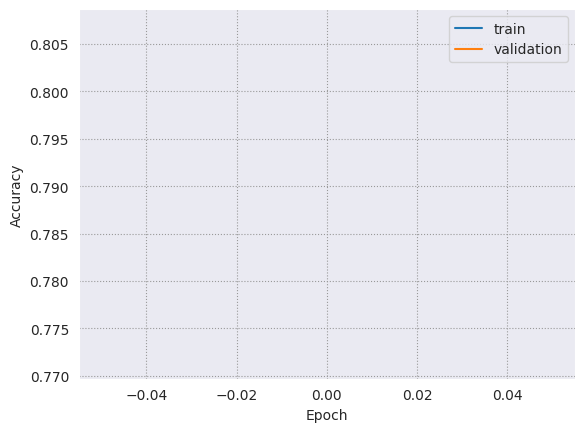

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

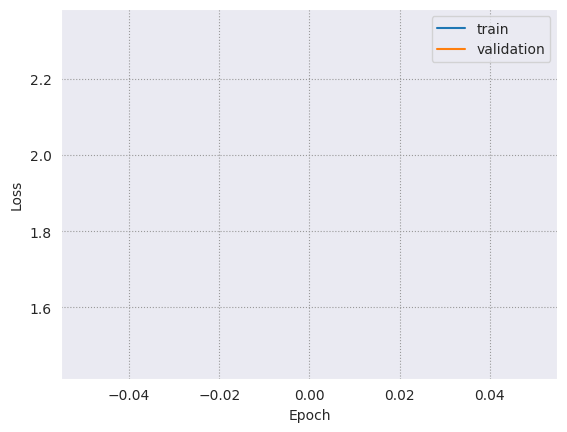

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'])
plt.show()

## Loss and accuracy

In [ ]:
loss1, accuracy1 = model.evaluate(tamil_padded, english_padded)

# Print the evaluation results
print(f"Loss: {loss1}")
print(f"Accuracy: {accuracy1}")

50/50 [==============================] - 1s 23ms/step - loss: 1.4562 - accuracy: 0.8069
Loss: 1.4561558961868286
Accuracy: 0.8069195747375488


## Evaluation with example

In [ ]:
def translate(sentence):
    sequence = tamil_tokenizer.toSequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    translation = model.predict(padded_sequence)
    translation = tf.argmax(translation, axis=-1).numpy()[0]
    translated_sentence = ' '.join([list(english_tokenizer.word_index.keys())[idx-1] for idx in translation if idx != 0])
    return translated_sentence

In [ ]:
tamil_sentence = example_sent
res1 = translate(tamil_sentence)
print(f"Tamil: {tamil_sentence}")
print(f"English: {res1}")

1/1 [==============================] - 1s 1s/step
Tamil: Inga enna nadakkuthu?
English: 


# Model ( GRU )

## Model Architecture

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tamil_tokenizer.word_index) + 1, output_dim=256, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(english_tokenizer.word_index) + 1, activation='softmax'))
])

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Model Training

In [ ]:
history2 = model3.fit(tamil_padded, english_padded, epochs=no_of_epochs, batch_size=size_batch,validation_split = 0.2)

20/20 [==============================] - 3s 139ms/step - loss: 1.4193 - accuracy: 0.8115 - val_loss: 1.5474 - val_accuracy: 0.7878


## Model Evaluation

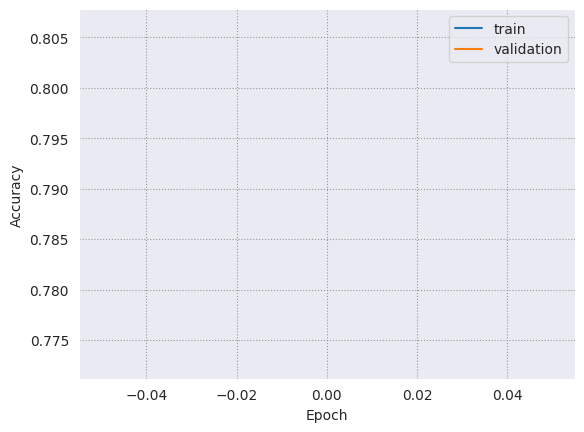

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

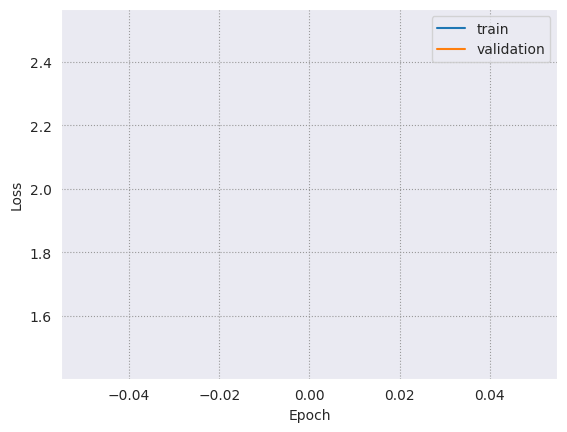

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'])
plt.show()

## Loss and accuracy

In [ ]:
loss2, accuracy2 = model3.evaluate(tamil_padded, english_padded)

# Print the evaluation results
print(f"Loss: {loss2}")
print(f"Accuracy: {accuracy2}")

50/50 [==============================] - 1s 19ms/step - loss: 1.4553 - accuracy: 0.8061
Loss: 1.4552993774414062
Accuracy: 0.806113600730896


## Evaluation with example

In [ ]:
def translate(sentence):
    sequence = tamil_tokenizer.toSequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    translation = model3.predict(padded_sequence)
    translation = tf.argmax(translation, axis=-1).numpy()[0]
    translated_sentence = ' '.join([list(english_tokenizer.word_index.keys())[idx-1] for idx in translation if idx != 0])
    return translated_sentence

In [ ]:
tamil_sentence = example_sent
res2 = translate(tamil_sentence)
print(f"Tamil: {tamil_sentence}")
print(f"English: {res2}")

1/1 [==============================] - 1s 1s/step
Tamil: Inga enna nadakkuthu?
English: 


# Combined model ( LSTM and GRU )

## Model Architecture

In [ ]:
input_layer = tf.keras.layers.Input(shape=(max_length,))
embedding_layer = tf.keras.layers.Embedding(input_dim=len(tamil_tokenizer.word_index) + 1, output_dim=256, input_length=max_length)(input_layer)
lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(embedding_layer)
gru_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True))(embedding_layer)
concatenated_output = tf.keras.layers.Concatenate()([lstm_output, gru_output])
dropout_layer = tf.keras.layers.Dropout(0.5)(concatenated_output)
output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(english_tokenizer.word_index) + 1, activation='softmax'))(dropout_layer)

# Create model
model_concat = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Compile the model with run_eagerly=True
model_concat.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

## Model Training

In [ ]:
# Train the model with validation data
history3 = model_concat.fit(tamil_padded, english_padded, epochs=no_of_epochs, batch_size=size_batch, validation_split=0.2)

# Disable eager execution after training
tf.config.run_functions_eagerly(False)

20/20 [==============================] - 7s 278ms/step - loss: 1.4255 - accuracy: 0.8106 - val_loss: 1.5755 - val_accuracy: 0.7865


## Model Evaluation

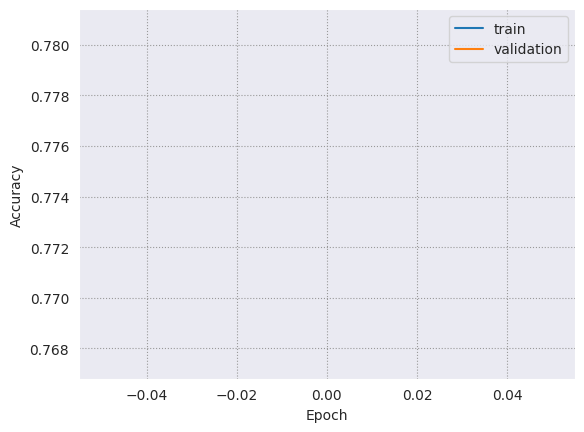

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

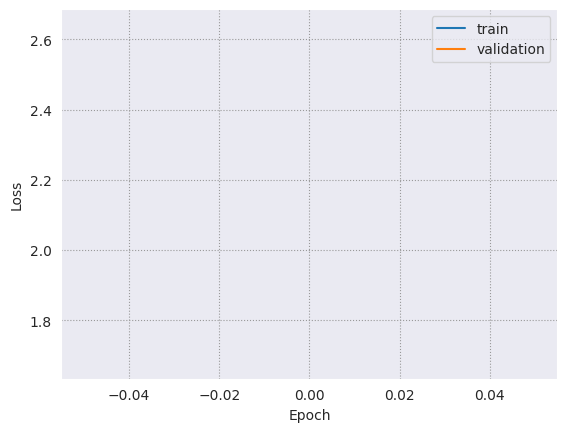

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'])
plt.show()

## Loss and accuracy

In [ ]:
loss3, accuracy3 = model_concat.evaluate(tamil_padded, english_padded)

# Print the evaluation results
print(f"Loss: {loss3}")
print(f"Accuracy: {accuracy3}")

50/50 [==============================] - 2s 41ms/step - loss: 1.4838 - accuracy: 0.8041
Loss: 1.4837806224822998
Accuracy: 0.8040620684623718


## Evaluation with example

In [ ]:
# Preprocess the input Tamil sentence
input_sequence = tamil_tokenizer.toSequences([example_sent])

# Pad the sequence to match the model's input length
input_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_length, padding='post')

# Get the predicted English translation from the model
predicted_indices = model_concat.predict(input_sequence_padded)

# Convert predicted indices to English words using the English tokenizer
predicted_words = []
for idx in np.argmax(predicted_indices, axis=-1)[0]:
    # Check if the index exists in the tokenizer's index_word dictionary
    if idx in english_tokenizer.index_word:
        predicted_words.append(english_tokenizer.index_word[idx])

# Join the words to form the translated sentence
res3 = ' '.join(predicted_words)

# Print the translated sentence
print("Translated Sentence:", res3)


1/1 [==============================] - 0s 47ms/step
Translated Sentence: is


# Transformer Model

## Model architecture

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout_rate):
        super(TransformerEncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.dropout1 = Dropout(dropout_rate)
        self.layer_norm1 = LayerNormalization(epsilon=1e-6)
        self.dense1 = Dense(ff_dim, activation='relu')
        self.dense2 = Dense(d_model)
        self.dropout2 = Dropout(dropout_rate)
        self.layer_norm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attention_output = self.multi_head_attention(inputs, inputs)
        attention_output = self.dropout1(attention_output)
        attention_output = self.layer_norm1(inputs + attention_output)
        ff_output = self.dense2(self.dense1(attention_output))
        ff_output = self.dropout2(ff_output)
        ff_output = self.layer_norm2(attention_output + ff_output)

        return ff_output

### `TransformerEncoderLayer` Class

This class defines a single encoder layer in a transformer model. It inherits from `tf.keras.layers.Layer`.

#### Attributes:

- `multi_head_attention`: A `MultiHeadAttention` layer, which computes multi-head self-attention.
- `dropout1`: A `Dropout` layer for the first dropout operation.
- `layer_norm1`: A `LayerNormalization` layer for the first layer normalization operation.
- `dense1`: A `Dense` layer for the first feedforward neural network.
- `dense2`: A `Dense` layer for the second feedforward neural network.
- `dropout2`: A `Dropout` layer for the second dropout operation.
- `layer_norm2`: A `LayerNormalization` layer for the second layer normalization operation.

#### Methods:

- `call(inputs)`: Method that defines the forward pass of the layer.
  - `inputs`: Input tensor to the layer.
  - Computes multi-head self-attention on the input tensor.
  - Applies dropout and layer normalization to the attention output.
  - Passes the normalized attention output through a feedforward neural network.
  - Applies dropout and layer normalization to the output of the feedforward neural network.
  - Returns the output tensor.



In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### `PositionalEncoding` Class

This class defines the positional encoding layer used in transformer models. It inherits from `tf.keras.layers.Layer`.

#### Attributes:

- `pos_encoding`: The positional encoding matrix computed using the `positional_encoding` method.

#### Methods:

- `__init__(self, max_len, d_model)`: Constructor method that initializes the positional encoding layer.
  - `max_len`: Maximum sequence length.
  - `d_model`: Dimensionality of the model.
  - Computes the positional encoding matrix using the `positional_encoding` method.

- `get_angles(self, pos, i, d_model)`: Method to compute the angle rates used in the positional encoding formula.
  - `pos`: Position indices.
  - `i`: Dimension indices.
  - `d_model`: Dimensionality of the model.
  - Computes the angle rates based on the provided position and dimension indices.

- `positional_encoding(self, position, d_model)`: Method to compute the positional encoding matrix.
  - `position`: Maximum sequence length.
  - `d_model`: Dimensionality of the model.
  - Computes the positional encoding matrix using sine and cosine functions.

- `call(self, inputs)`: Method that defines the forward pass of the layer.
  - `inputs`: Input tensor to the layer.
  - Adds the positional encoding to the input tensor.
  - Returns the sum of the input tensor and the positional encoding.



In [ ]:
def transformer_model(input_vocab_size, target_vocab_size, max_length, d_model=128, num_heads=4, ff_dim=512, dropout=0.1):
    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(input_vocab_size, d_model, input_length=max_length)(inputs)
    positional_encoding = PositionalEncoding(max_length, d_model)(embedding_layer)
    x = Dropout(dropout)(positional_encoding)

    for _ in range(2):  # Stack of 2 encoder layers
        x = TransformerEncoderLayer(d_model, num_heads, ff_dim, dropout)(x)

    outputs = Dense(target_vocab_size, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model1 = transformer_model(input_vocab_size, target_vocab_size, max_length)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [ ]:
# Assuming you have your padded sequences tamil_padded and english_padded
history4 = model1.fit(tamil_padded, english_padded, batch_size=size_batch, epochs=no_of_epochs, validation_split = 0.2)

20/20 [==============================] - 2s 106ms/step - loss: 1.8212 - accuracy: 0.8107 - val_loss: 1.9544 - val_accuracy: 0.7864


## Model evaluation

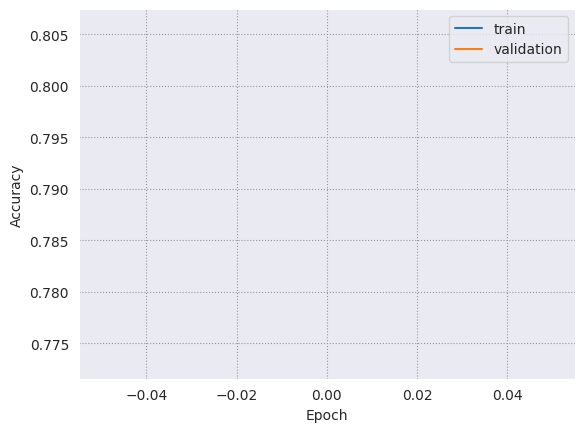

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

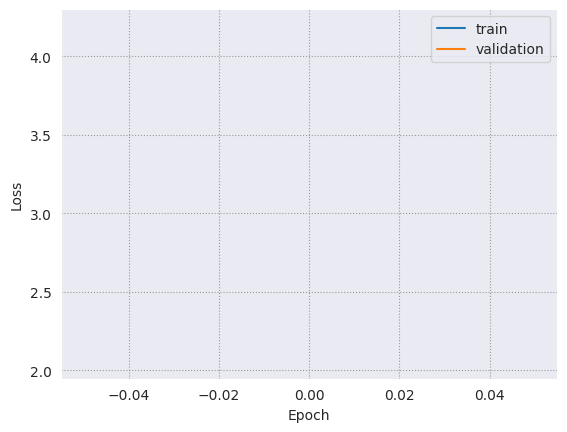

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'])
plt.show()

## Loss and accuracy

In [ ]:
loss4, accuracy4 = model1.evaluate(tamil_padded, english_padded)

# Print the evaluation results
print(f"Loss: {loss4}")
print(f"Accuracy: {accuracy4}")

50/50 [==============================] - 0s 9ms/step - loss: 2.0544 - accuracy: 0.8058
Loss: 2.0543837547302246
Accuracy: 0.8058205246925354


## Evaluation with example

In [ ]:
def translate(tamil_sentence, tamil_tokenizer, english_tokenizer, model, max_length):
    # Preprocess the Tamil sentence
    tamil_sentence = lowercase_sentences([tamil_sentence])[0]  # Convert to lowercase
    tamil_sequence = tamil_tokenizer.toSequences([tamil_sentence])[0]  # Convert to sequence of integers

    # Pad the Tamil sequence
    tamil_padded = pad_sequences([tamil_sequence], maxlen=max_length, padding='post')

    # Translate the Tamil sequence to English
    english_padded = model1.predict(tamil_padded)

    # Decode the English sequence
    english_sequence = [english_tokenizer.index_word.get(np.argmax(token), '') for token in english_padded[0]]
    english_translation = ' '.join(english_sequence).strip()

    return english_translation


In [ ]:
tamil_sentence = example_sent
res4 = translate(tamil_sentence, tamil_tokenizer, english_tokenizer, model, max_length)
print("Translated English sentence:", res4)

1/1 [==============================] - 0s 290ms/step
Translated English sentence: 


# Comparision of results

In [ ]:
accuracy = [accuracy1,accuracy2,accuracy3,accuracy4]
loss = [loss1,loss2,loss3,loss4]
l = ["LSTM","GRU","LSTM and GRU","Positional Encoding"]
res = [res1,res2,res3,res4]

## Accuracy comparision

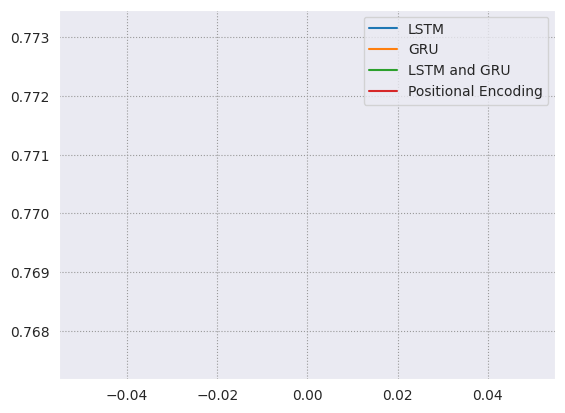

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.legend(l)
plt.show()

## Validation Accuracy comparision

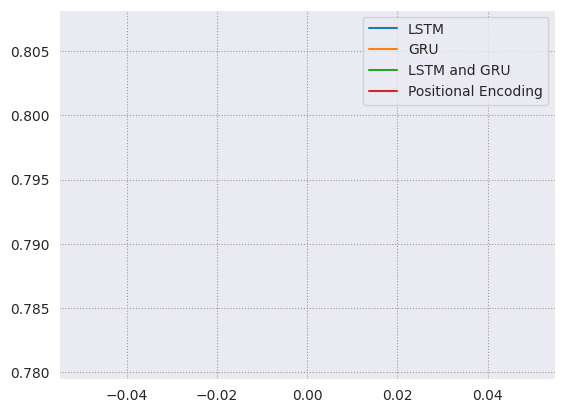

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.legend(l)
plt.show()

## Loss comparision

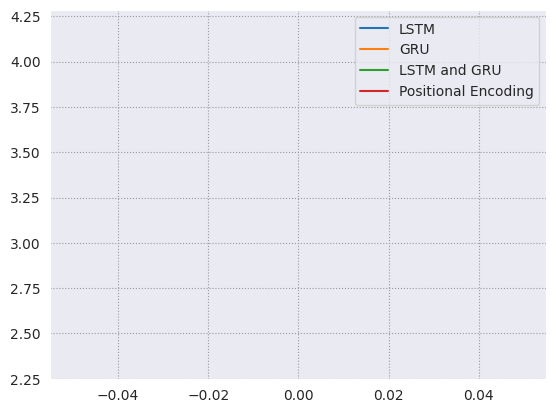

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.legend(l)
plt.show()

## Validation Loss comparision

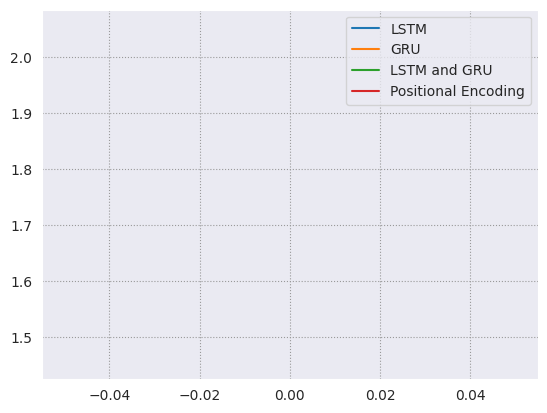

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.legend(l)
plt.show()

## Comparision of Example Sentance

In [ ]:
print("Test Sentence = "+example_sent)
for i in range(len(l)):
  print("Translated by",l[i],"=",res[i])

Test Sentence = Inga enna nadakkuthu?
Translated by LSTM = 
Translated by GRU = 
Translated by LSTM and GRU = is
Translated by Positional Encoding = 


## Overall Comaparision of Accuracy and Loss

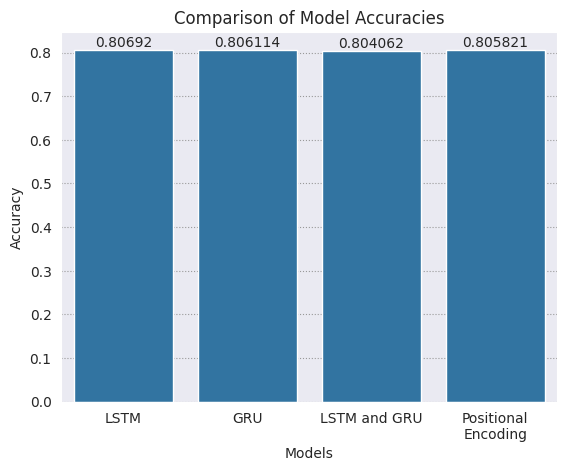

In [ ]:
l1 = ["LSTM","GRU","LSTM and GRU","Positional\nEncoding"]
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax = sns.barplot(x=l, y=accuracy, errorbar=None,legend="brief")
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

# Displaying the histogram
plt.show()

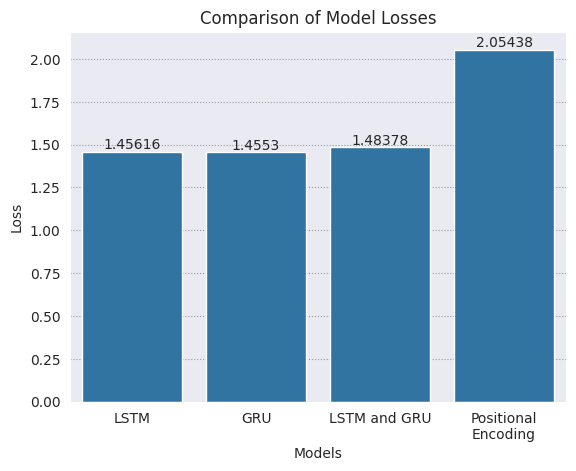

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax = sns.barplot(x=l1, y=loss, errorbar=None,legend="brief")
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Comparison of Model Losses')

# Displaying the histogram
plt.show()

# Evaluation metrics

In [ ]:
for i in range(len(res)):
  print("Model =",l[i])
  # Initialize ROUGE scorer
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

  # Compute ROUGE scores
  scores = scorer.score(res[i], example_sent_translation)

  # Print ROUGE scores
  print("ROUGE-1 Precision:", scores['rouge1'].precision)
  print("ROUGE-1 Recall:", scores['rouge1'].recall)
  print("ROUGE-1 F1 Score:", scores['rouge1'].fmeasure)
  print("ROUGE-L Precision:", scores['rougeL'].precision)
  print("ROUGE-L Recall:", scores['rougeL'].recall)
  print("ROUGE-L F1 Score:", scores['rougeL'].fmeasure)
  print()
  print()

Model = LSTM
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
ROUGE-L Precision: 0
ROUGE-L Recall: 0
ROUGE-L F1 Score: 0


Model = GRU
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
ROUGE-L Precision: 0
ROUGE-L Recall: 0
ROUGE-L F1 Score: 0


Model = LSTM and GRU
ROUGE-1 Precision: 0.25
ROUGE-1 Recall: 1.0
ROUGE-1 F1 Score: 0.4
ROUGE-L Precision: 0.25
ROUGE-L Recall: 1.0
ROUGE-L F1 Score: 0.4


Model = Positional Encoding
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
ROUGE-L Precision: 0
ROUGE-L Recall: 0
ROUGE-L F1 Score: 0




In [ ]:
res4

''